# ConvLSTM Seq2Seq

In [1]:
import os
import numpy as np
import datetime
import time

import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
plt.style.use('sonia.mplstyle')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

PATH = './data/'

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


## 1. Get the data

In [3]:
class ThunderstormDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.dataset_sizes = [np.load(file_path, mmap_mode='r').shape[0] for file_path in file_paths]
        self.cumulative_sizes = np.cumsum(self.dataset_sizes)
        self.total_size = self.cumulative_sizes[-1]

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        # Find which file this idx belongs to
        file_idx = np.searchsorted(self.cumulative_sizes, idx, side='right')
        if file_idx == 0:
            within_file_idx = idx
        else:
            within_file_idx = idx - self.cumulative_sizes[file_idx - 1]
        
        file_path = self.file_paths[file_idx]
        data = np.load(file_path, mmap_mode='r')
        item = data[within_file_idx]
        
        # Split the item into inputs and targets
        inputs = torch.tensor(item[:6, :, :, :], dtype=torch.float32).permute(0, 3, 1, 2)  # The first 6 images
        targets = torch.tensor(item[6:, :, :, :], dtype=torch.float32).permute(0, 3, 1, 2)  # The last 6 images
        del data
        return inputs, targets

In [4]:
train_file_paths = [PATH + file for file in sorted(os.listdir(PATH))][0:40]
test_file_paths = [PATH + file for file in sorted(os.listdir(PATH))][40]

In [5]:
train_dataset = ThunderstormDataset(train_file_paths)
test_dataset = ThunderstormDataset([test_file_paths])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

## 2. Create ConvLSTM model

In [6]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2  # Ensures output has the same size
        self.bias = bias
        
        self.conv = nn.Conv2d(
            in_channels=self.input_channels + self.hidden_channels,
            out_channels=4 * self.hidden_channels,  # Number of gates
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )

    def forward(self, input_tensor, hidden_state):
        h_cur, c_cur = hidden_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # Concatenate along channel axis
        combined_conv = self.conv(combined)
        i, f, o, g = torch.split(combined_conv, self.hidden_channels, dim=1)
        
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (
            torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device),
            torch.zeros(batch_size, self.hidden_channels, height, width, device=self.conv.weight.device)
        )

In [7]:
class ConvLSTMEncoder(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers):
        super(ConvLSTMEncoder, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            cur_input_channels = self.input_channels if i == 0 else self.hidden_channels
            self.cells.append(
                ConvLSTMCell(
                    input_channels=cur_input_channels,
                    hidden_channels=self.hidden_channels,
                    kernel_size=self.kernel_size
                ).to(device)
            )

    def forward(self, input_tensor):
        batch_size, seq_len, _, height, width = input_tensor.size()
        hidden_state = self._init_hidden(batch_size, (height, width))
        
        layer_output_list = []
        last_state_list = []

        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cells[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :], 
                    hidden_state=[h, c]
                )
                output_inner.append(h)
            
            layer_output = torch.stack(output_inner, dim=1)  # [b, t, hidden_channels, h, w]
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        return [self.cells[i].init_hidden(batch_size, image_size) for i in range(self.num_layers)]

In [8]:
class ConvLSTMDecoder(nn.Module):
    def __init__(self, hidden_channels, output_channels, kernel_size, num_layers):
        super(ConvLSTMDecoder, self).__init__()
        self.hidden_channels = hidden_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        
        self.cells = nn.ModuleList()
        for i in range(num_layers):
            cur_input_channels = hidden_channels if i == 0 else hidden_channels
            self.cells.append(
                ConvLSTMCell(
                    input_channels=cur_input_channels,
                    hidden_channels=self.hidden_channels,
                    kernel_size=self.kernel_size
                ).to(device)
            )

        self.decoder = nn.Conv2d(hidden_channels, output_channels, kernel_size=1, padding=0).to(device)
        self.adjust_channels = nn.Conv2d(output_channels, hidden_channels, kernel_size=3, padding=1).to(device)

    def forward(self, last_state_list, future_seq_len):
        h, c = last_state_list[-1]  # Start from the last hidden and cell states of the encoder

        predicted_sequence = []
        for _ in range(future_seq_len):
            next_frame = self.decoder(h)
            next_frame_adjusted = self.adjust_channels(next_frame)
            predicted_sequence.append(next_frame)
            h, c = self.cells[-1](input_tensor=next_frame_adjusted, hidden_state=[h, c])

        predicted_sequence = torch.stack(predicted_sequence, dim=1)
        return predicted_sequence

In [9]:
class ConvLSTMSeq2Seq(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels, kernel_size, num_layers):
        super(ConvLSTMSeq2Seq, self).__init__()
        self.encoder = ConvLSTMEncoder(input_channels, hidden_channels, kernel_size, num_layers).to(device)
        self.decoder = ConvLSTMDecoder(hidden_channels, output_channels, kernel_size, num_layers).to(device)

    def forward(self, input_sequence, future_seq_len):
        _, last_state_list = self.encoder(input_sequence)
        predicted_sequence = self.decoder(last_state_list, future_seq_len)
        return predicted_sequence

## 3. Specify training loop

In [10]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = np.Inf

    def __call__(self, test_loss, model):
        score = -test_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(test_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(test_loss, model)
            self.counter = 0

    def save_checkpoint(self, test_loss, model):
        self.best_loss = test_loss
        torch.save(model.state_dict(), 'results/checkpoint.pt')

In [11]:
def evaluate(model, data_loader, criterion, seq_len):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, seq_len)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [12]:
def train(model, train_loader, test_loader, seq_len, num_epochs, learning_rate, device):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    early_stopping = EarlyStopping(patience=5, verbose=True)

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        tic = time.perf_counter()
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs, seq_len)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
   
        train_loss = evaluate(model, train_loader, criterion, seq_len)
        test_loss = evaluate(model, test_loader, criterion, seq_len)
        scheduler.step(test_loss)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        toc = time.perf_counter()
        sec = round(toc - tic)
        print(f'Epoch {epoch + 1:>2}/{num_epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}, Time: {str(datetime.timedelta(seconds=sec))}')

        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print('Early stopping')
            break

    # Load the best model
    model.load_state_dict(torch.load('results/checkpoint.pt'))

    return train_losses, test_losses

## 4. Initialize and train model

In [13]:
input_channels = 1
hidden_channels = 64
output_channels = 1
seq_len = 6
kernel_size = 3
num_layers = 2
batch_size = 1
learning_rate = 0.001
num_epochs = 20

In [14]:
conv_lstm = ConvLSTMSeq2Seq(input_channels, hidden_channels, output_channels, kernel_size, num_layers).to(device)

In [15]:
train_losses, test_losses = train(conv_lstm, train_loader, test_loader, seq_len, num_epochs, learning_rate, device)

Epoch  1/20, Train Loss: 945.99, Test Loss: 910.35, Time: 0:47:50
Epoch  2/20, Train Loss: 970.90, Test Loss: 939.72, Time: 0:47:55
EarlyStopping counter: 1 out of 5
Epoch  3/20, Train Loss: 949.87, Test Loss: 910.72, Time: 0:47:39
EarlyStopping counter: 2 out of 5
Epoch  4/20, Train Loss: 965.78, Test Loss: 924.49, Time: 0:47:32
EarlyStopping counter: 3 out of 5
Epoch  5/20, Train Loss: 988.85, Test Loss: 946.45, Time: 0:47:39
EarlyStopping counter: 4 out of 5
Epoch  6/20, Train Loss: 898.36, Test Loss: 848.47, Time: 0:47:36
Epoch  7/20, Train Loss: 879.62, Test Loss: 824.40, Time: 0:47:35
Epoch  8/20, Train Loss: 863.56, Test Loss: 808.92, Time: 0:47:58
Epoch  9/20, Train Loss: 842.26, Test Loss: 788.95, Time: 0:48:04
Epoch 10/20, Train Loss: 853.34, Test Loss: 800.13, Time: 0:47:48
EarlyStopping counter: 1 out of 5
Epoch 11/20, Train Loss: 836.81, Test Loss: 780.33, Time: 0:47:42
Epoch 12/20, Train Loss: 833.77, Test Loss: 777.35, Time: 0:47:40
Epoch 13/20, Train Loss: 830.50, Test 

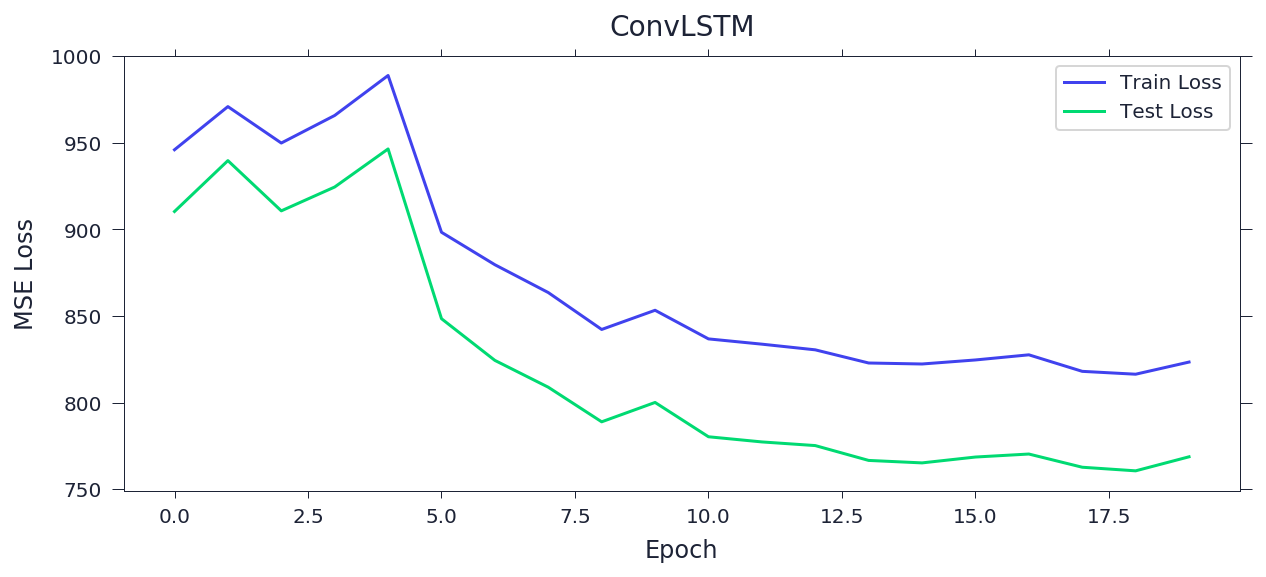

In [16]:
ax = subplots(figsize=(10, 4))[1]
ax.plot(train_losses, label='Train Loss')
ax.plot(test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('ConvLSTM')
plt.legend();

In [17]:
criterion = nn.MSELoss()
test_loss = evaluate(conv_lstm, test_loader, criterion, seq_len)
print(f'Test RMSE: {test_loss ** 0.5:.4f}')

Test RMSE: 27.5801


In [18]:
model_name = 'ConvLSTM'
torch.save(conv_lstm.state_dict(), f'results/{model_name}.pt')
np.save(f'results/{model_name}_train_losses.npy', np.array(train_losses))
np.save(f'results/{model_name}_test_losses.npy', np.array(test_losses))